# IMPORTS, FUNCTIONS AND OTHER STATIC STUFF

In [1]:
from lime import our_lime
import os
import numpy as np
import random
from PIL import Image
from pathlib import Path
from skimage.segmentation import mark_boundaries
import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F


### STATIC PATHS ###
ROOT_DIR = Path.cwd()
CAT_IMG_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'predict' / 'cat'
DOG_IMG_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'predict' / 'dog'
BLACKBOX_CLASSIFIER_WEIGHT_PATH = ROOT_DIR / 'data' / 'dogs_vs_cats' / 'catvdog.pth'
classes = ["Cat", "Dog"]

### FUNCTIONS ###
def get_image(path):
    #randomly pick a dog or cat image from image folder
    img_files = list(path.glob('*.jpg*'))
    img_file = random.choice(img_files)
    img_path_file = path / img_file
    with open(os.path.abspath(img_path_file), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
    
#check if paths are valid
if not Path(CAT_IMG_PATH):
    print(f"Warning: The cat image directory was not found:\n{CAT_IMG_PATH}")
if not Path(DOG_IMG_PATH):
    print(f"Warning: The dog image directory was not found:\n{DOG_IMG_PATH}")
if not Path(BLACKBOX_CLASSIFIER_WEIGHT_PATH):
    print(f"Warning: The blackbox classifier weights were not found:\n{BLACKBOX_CLASSIFIER_WEIGHT_PATH}")

# Demo: ImageObject Class

<PIL.Image.Image image mode=RGB size=500x496 at 0x25DF66A0400>
None
None


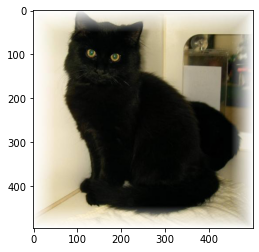

In [2]:
#pick random cat image
random_cat_image = get_image(CAT_IMG_PATH)
ImageObjectDemo = our_lime.ImageObject(random_cat_image)

#Attributes fugde_image and superpixels are initialized as None
print(ImageObjectDemo.original_image, ImageObjectDemo.fudged_image, ImageObjectDemo.superpixels, sep="\n")
ImageObjectDemo.show()

In [3]:
raw_img = get_image(CAT_IMG_PATH)
img = our_lime.ImageObject(raw_img)
explainer = our_lime.Explainer(
    our_lime.SegmentationMethod("quickshift")
)
explainer.segment_image(img, kernel_size=4, max_dist=200, ratio=0.2 ) #call Segmentation Method

#superpixels are saved
img.superpixels 

array([[  5,   5,   5, ...,   7,   7,   7],
       [  5,   5,   5, ...,   7,   7,   7],
       [  5,   5,   5, ...,   7,   7,   7],
       ...,
       [295, 295, 295, ..., 309, 309, 309],
       [295, 295, 295, ..., 309, 309, 309],
       [295, 295, 295, ..., 309, 309, 309]], dtype=int64)

# Demo: SegmentationMethod Class

In [17]:
SegmentationMethodDemo = our_lime.SegmentationMethod("quickshift")
superpixels = SegmentationMethodDemo.segment(ImageObjectDemo.original_imagel_image, kernel_size=4, max_dist=200, ratio=0.2)
ImageObjectDemo.change_attribute(new_superpixel_value = superpixels)
print(ImageObjectDemo.superpixels, f"\nShape {np.shape(ImageObjectDemo.superpixels)}")

[[ 4  4  4 ...  3  3  3]
 [ 4  4  4 ...  3  3  3]
 [ 4  4  4 ...  3  3  3]
 ...
 [63 63 63 ... 70 70 70]
 [63 63 63 ... 70 70 70]
 [63 63 63 ... 70 70 70]] 
Shape (345, 350)
